In [1]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
def parser(x):
    return datetime.strptime(x,'%Y')

In [3]:
df = pd.read_csv('mel_data_world.csv', header=0, parse_dates=[3], squeeze=True, date_parser=parser)[:-2]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Area     59 non-null     object        
 1   Item     59 non-null     object        
 2   Element  59 non-null     object        
 3   Year     59 non-null     datetime64[ns]
 4   Source   59 non-null     object        
 5   Unit     59 non-null     object        
 6   Value    59 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.4+ KB


In [5]:
del df['Area']
del df['Item']
del df['Element']
del df['Source']
del df['Unit']
df.head()

,Year,Value
0,1961-01-01,65345.0181
1,1962-01-01,66301.1211
2,1963-01-01,67010.1455
3,1964-01-01,67925.5358
4,1965-01-01,69192.9603


In [6]:
train = df[:int(len(df)*.92)]
test = df[len(train):]

In [7]:
test.tail

<bound method NDFrame.tail of          Year        Value
54 2015-01-01   97809.4203
55 2016-01-01   98853.5406
56 2017-01-01   99295.5717
57 2018-01-01   99918.7410
58 2019-01-01  100834.1659>

In [8]:
X= train[['Year']]
y= train.iloc[:,1]

In [9]:
train_ds= pd.DataFrame()
train_ds['ds'] = X["Year"]
train_ds['y']=y
train_ds.tail(2)

,ds,y
52,2013-01-01,96369.3028
53,2014-01-01,96946.5973


In [10]:
prop_model = Prophet()
prop_model.fit(train_ds)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future= prop_model.make_future_dataframe(periods=len(test), freq='YS')
prop_pred = prop_model.predict(future)
prop_pred.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
54,2015-01-01,35313.604747,97628.116913,98788.991540,35300.895409,35338.332625,62871.305990,62871.305990,62871.305990,62871.305990,62871.305990,62871.305990,0.0,0.0,0.0,98184.910737
55,2016-01-01,35948.372910,98246.984659,99497.503727,35867.089602,36061.606824,62918.007550,62918.007550,62918.007550,62918.007550,62918.007550,62918.007550,0.0,0.0,0.0,98866.380460
56,2017-01-01,36584.880165,98664.470744,99977.715368,36410.305024,36817.254358,62699.410722,62699.410722,62699.410722,62699.410722,62699.410722,62699.410722,0.0,0.0,0.0,99284.290887
57,2018-01-01,37219.648328,99289.258836,100764.286093,36918.859375,37611.194342,62798.318866,62798.318866,62798.318866,62798.318866,62798.318866,62798.318866,0.0,0.0,0.0,100017.967194
58,2019-01-01,37854.416492,99899.191438,101553.994916,37394.064838,38385.020294,62871.305990,62871.305990,62871.305990,62871.305990,62871.305990,62871.305990,0.0,0.0,0.0,100725.722481


In [12]:
prop_prediction = pd.DataFrame({"Year" : prop_pred[-len(test):]['ds'], "Prediction" : prop_pred[-len(test):]['yhat']})
prop_prediction = prop_prediction.set_index("Year")
prop_prediction.index.freq = 'YS'

In [13]:
test.columns = ['ds','y']

In [14]:
test.head()

,ds,y
54,2015-01-01,97809.4203
55,2016-01-01,98853.5406
56,2017-01-01,99295.5717
57,2018-01-01,99918.7410
58,2019-01-01,100834.1659


In [15]:
test["Prophet_Pred_Val"] = prop_prediction['Prediction'].values
test = test.set_index("ds")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



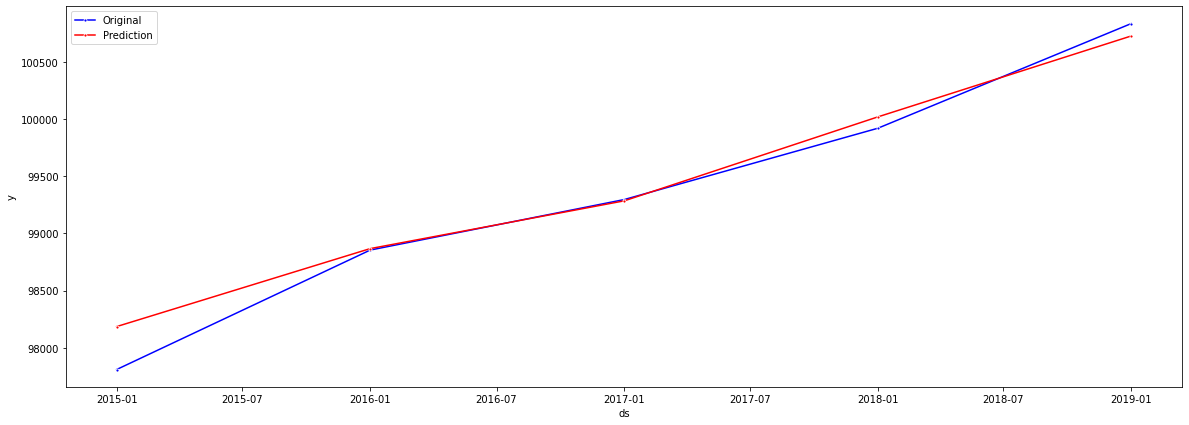

In [16]:
plt.figure(figsize=(20,7))
sns.lineplot(x=test.index, y=test["y"], color="blue",marker='.', label='Original')
sns.lineplot(x=test.index, y= test["Prophet_Pred_Val"],color='red',marker='.',label='Prediction')

In [17]:
print('Test Mean Absolute Error for Prophet: ', mean_absolute_error(test['y'],test['Prophet_Pred_Val']))
print('Test Root Mean Squared Error for Prophet: ', np.sqrt(rmse(test['y'], test['Prophet_Pred_Val'])))
print('Test Mean Absolute Percentage Error for Prophet: ', np.mean(np.abs((test['y'] - test['Prophet_Pred_Val']) / test['y'])) * 100)

Test Mean Absolute Error for Prophet:  121.45614457343473
Test Root Mean Squared Error for Prophet:  13.434817484479124
Test Mean Absolute Percentage Error for Prophet:  0.12302057622388866
